## 1. 사용할 패키지 불러오기

In [5]:
from utils import ConstructDataset, ConstructInferenceDataset, prepare_dataset
from models.visualize import plot_loss, plot_score, plot_acc, visualize_inference
from models import ModelFactory, LossFactory, fit 
from models.inference import get_samples, predict_image_mask_miou, miou_score, pixel_acc
import albumentations as A
from torch.utils.data import DataLoader
from torchvision import transforms as T
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import os
import torch
import torch.nn as nn
import pandas as pd

/home/jongwook95.lee/miniforge3/envs/torch_segmentation_assets/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 데이터셋 불러오기

### (1) Dataset Directory Setting

In [6]:
train_image_dir = './dataset/images/train'
valid_image_dir = './dataset/images/val'
test_image_dir = './dataset/images/test'


train_mask_dir = './dataset/labels/train'
valid_mask_dir = './dataset/labels/val'
test_mask_dir = './dataset/labels/test'

### (2) Prepare Dataset

In [7]:
train_dataset = prepare_dataset(image_dir = train_image_dir, mask_dir = train_mask_dir)
valid_dataset = prepare_dataset(image_dir = valid_image_dir, mask_dir = valid_mask_dir)
test_dataset = prepare_dataset(image_dir = test_image_dir, mask_dir = test_image_dir, label_exist = False)

The number of image files: 7000
The number of mask files: 7000
The number of image files: 1000
The number of mask files: 1000
The number of image files: 2000


### (3) Train Dataset으로 부터 Validation Dataset 생성

In [8]:
valid_split = 0.1

In [9]:
train_dataset['Image'] = train_dataset['Image'] + valid_dataset['Image']
train_dataset['Mask'] = train_dataset['Mask'] + valid_dataset['Mask']

In [10]:
train_image_list, valid_image_list, train_mask_list, valid_mask_list = train_test_split(train_dataset['Image'], train_dataset['Mask'], test_size=valid_split, random_state=1004)
test_image_list = test_dataset['Image']
test_mask_list = test_dataset['Mask']

## 3. Parameter Setting

### (1) Transformation Setting

In [11]:
input_size = (640, 320)  # devided by 32
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [12]:
train_transform = A.Compose([A.Resize(input_size[0], input_size[1], interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

validation_transform = A.Compose([A.Resize(input_size[0], input_size[1], interpolation=cv2.INTER_NEAREST)])

### (2) Make Torch DataLoader

In [13]:
batch_size = 4

In [14]:
train_set = ConstructDataset(train_image_list, train_mask_list, mean, std, train_transform)
val_set = ConstructDataset(valid_image_list, valid_mask_list, mean, std, validation_transform)

In [15]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)     

## 4. Model

### (1) Parameter Setting

In [16]:
architecture = 'unet' ## ['unet', 'fpn', 'DeepLabV3Plus']
encoder_name = 'mobilenet_v2'
in_channels = 3
class_num = 19
experiment_path = './result'
os.makedirs(experiment_path, exist_ok=True)
os.makedirs(os.path.join(experiment_path, architecture + '+' + encoder_name), exist_ok=True)
save_model_path = os.path.join(experiment_path, architecture + '+' + encoder_name)


### (2) Construct Model

In [17]:
model = ModelFactory(architecture = architecture, encoder_name = encoder_name, in_channels = in_channels, class_num = class_num)

In [71]:
model = ModelFactory(architecture = architecture, encoder_name = 'aa', in_channels = in_channels, class_num = class_num)

KeyError: "Wrong encoder name `aa`, supported encoders: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_lite1', 'timm-tf_efficientnet_lite2', 'timm-tf_efficientnet_lite3', 'timm-tf_efficientnet_lite4', 'timm-resnest14d', 'timm-resnest26d', 'timm-resnest50d', 'timm-resnest101e', 'timm-resnest200e', 'timm-resnest269e', 'timm-resnest50d_4s2x40d', 'timm-resnest50d_1s4x24d', 'timm-res2net50_26w_4s', 'timm-res2net101_26w_4s', 'timm-res2net50_26w_6s', 'timm-res2net50_26w_8s', 'timm-res2net50_48w_2s', 'timm-res2net50_14w_8s', 'timm-res2next50', 'timm-regnetx_002', 'timm-regnetx_004', 'timm-regnetx_006', 'timm-regnetx_008', 'timm-regnetx_016', 'timm-regnetx_032', 'timm-regnetx_040', 'timm-regnetx_064', 'timm-regnetx_080', 'timm-regnetx_120', 'timm-regnetx_160', 'timm-regnetx_320', 'timm-regnety_002', 'timm-regnety_004', 'timm-regnety_006', 'timm-regnety_008', 'timm-regnety_016', 'timm-regnety_032', 'timm-regnety_040', 'timm-regnety_064', 'timm-regnety_080', 'timm-regnety_120', 'timm-regnety_160', 'timm-regnety_320', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d', 'timm-mobilenetv3_large_075', 'timm-mobilenetv3_large_100', 'timm-mobilenetv3_large_minimal_100', 'timm-mobilenetv3_small_075', 'timm-mobilenetv3_small_100', 'timm-mobilenetv3_small_minimal_100', 'timm-gernet_s', 'timm-gernet_m', 'timm-gernet_l', 'mit_b0', 'mit_b1', 'mit_b2', 'mit_b3', 'mit_b4', 'mit_b5', 'mobileone_s0', 'mobileone_s1', 'mobileone_s2', 'mobileone_s3', 'mobileone_s4']"

## 5. Training

### (1) Loss, Optimizer 정의

In [18]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = LossFactory(loss_name = 'crossentropy').get_loss_fn()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

### (2) Fit

In [19]:
history = fit(epoch, model, train_dataloader, valid_dataloader, criterion, optimizer, sched, save_model_path, device)

100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Loss Decreasing.. inf >> 0.688 
Epoch:1/30.. Train Loss: 1.079.. Val Loss: 0.688.. Train mIoU:0.224.. Val mIoU: 0.263.. Train Acc:0.747.. Val Acc:0.820.. Time: 10.43m


100%|██████████| 200/200 [00:21<00:00,  9.23it/s]


Loss Decreasing.. 0.688 >> 0.605 
Epoch:2/30.. Train Loss: 0.720.. Val Loss: 0.605.. Train mIoU:0.262.. Val mIoU: 0.297.. Train Acc:0.803.. Val Acc:0.835.. Time: 9.94m


100%|██████████| 200/200 [00:20<00:00, 10.00it/s]


Loss Not Decrease for 1 time
Epoch:3/30.. Train Loss: 0.675.. Val Loss: 0.611.. Train mIoU:0.282.. Val mIoU: 0.303.. Train Acc:0.811.. Val Acc:0.831.. Time: 7.23m


100%|██████████| 200/200 [00:20<00:00,  9.78it/s]


Loss Decreasing.. 0.611 >> 0.608 
Epoch:4/30.. Train Loss: 0.661.. Val Loss: 0.608.. Train mIoU:0.290.. Val mIoU: 0.305.. Train Acc:0.814.. Val Acc:0.828.. Time: 7.26m


100%|██████████| 200/200 [00:20<00:00,  9.97it/s]


Loss Decreasing.. 0.608 >> 0.591 
saving model...
Epoch:5/30.. Train Loss: 0.655.. Val Loss: 0.591.. Train mIoU:0.294.. Val mIoU: 0.316.. Train Acc:0.815.. Val Acc:0.836.. Time: 7.27m


100%|██████████| 200/200 [00:20<00:00,  9.89it/s]


Loss Decreasing.. 0.591 >> 0.574 
Epoch:6/30.. Train Loss: 0.648.. Val Loss: 0.574.. Train mIoU:0.299.. Val mIoU: 0.320.. Train Acc:0.817.. Val Acc:0.838.. Time: 7.29m


100%|██████████| 200/200 [00:20<00:00,  9.64it/s]


Loss Decreasing.. 0.574 >> 0.561 
Epoch:7/30.. Train Loss: 0.642.. Val Loss: 0.561.. Train mIoU:0.305.. Val mIoU: 0.333.. Train Acc:0.818.. Val Acc:0.841.. Time: 7.27m


100%|██████████| 200/200 [00:20<00:00,  9.88it/s]


Loss Not Decrease for 2 time
Epoch:8/30.. Train Loss: 0.628.. Val Loss: 0.594.. Train mIoU:0.310.. Val mIoU: 0.317.. Train Acc:0.822.. Val Acc:0.834.. Time: 7.25m


100%|██████████| 200/200 [00:20<00:00,  9.86it/s]


Loss Decreasing.. 0.594 >> 0.563 
Epoch:9/30.. Train Loss: 0.613.. Val Loss: 0.563.. Train mIoU:0.315.. Val mIoU: 0.341.. Train Acc:0.825.. Val Acc:0.840.. Time: 7.27m


100%|██████████| 200/200 [00:19<00:00, 10.03it/s]


Loss Decreasing.. 0.563 >> 0.524 
Epoch:10/30.. Train Loss: 0.594.. Val Loss: 0.524.. Train mIoU:0.324.. Val mIoU: 0.346.. Train Acc:0.831.. Val Acc:0.851.. Time: 7.25m


100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


Loss Not Decrease for 3 time
Epoch:11/30.. Train Loss: 0.580.. Val Loss: 0.533.. Train mIoU:0.332.. Val mIoU: 0.356.. Train Acc:0.835.. Val Acc:0.850.. Time: 7.49m


100%|██████████| 200/200 [00:23<00:00,  8.57it/s]


Loss Decreasing.. 0.533 >> 0.503 
saving model...
Epoch:12/30.. Train Loss: 0.566.. Val Loss: 0.503.. Train mIoU:0.337.. Val mIoU: 0.356.. Train Acc:0.838.. Val Acc:0.856.. Time: 7.85m


100%|██████████| 200/200 [00:21<00:00,  9.38it/s]


Loss Decreasing.. 0.503 >> 0.494 
Epoch:13/30.. Train Loss: 0.555.. Val Loss: 0.494.. Train mIoU:0.343.. Val mIoU: 0.361.. Train Acc:0.841.. Val Acc:0.857.. Time: 8.20m


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


Loss Not Decrease for 4 time
Epoch:14/30.. Train Loss: 0.540.. Val Loss: 0.500.. Train mIoU:0.349.. Val mIoU: 0.383.. Train Acc:0.845.. Val Acc:0.855.. Time: 7.24m


100%|██████████| 200/200 [00:20<00:00,  9.78it/s]


Loss Decreasing.. 0.500 >> 0.473 
Epoch:15/30.. Train Loss: 0.531.. Val Loss: 0.473.. Train mIoU:0.354.. Val mIoU: 0.388.. Train Acc:0.847.. Val Acc:0.864.. Time: 7.23m


100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Loss Decreasing.. 0.473 >> 0.470 
Epoch:16/30.. Train Loss: 0.520.. Val Loss: 0.470.. Train mIoU:0.361.. Val mIoU: 0.388.. Train Acc:0.851.. Val Acc:0.864.. Time: 7.38m


100%|██████████| 200/200 [00:20<00:00,  9.79it/s]


Loss Decreasing.. 0.470 >> 0.463 
Epoch:17/30.. Train Loss: 0.506.. Val Loss: 0.463.. Train mIoU:0.367.. Val mIoU: 0.389.. Train Acc:0.855.. Val Acc:0.868.. Time: 7.25m


100%|██████████| 200/200 [00:19<00:00, 10.05it/s]


Loss Decreasing.. 0.463 >> 0.457 
saving model...
Epoch:18/30.. Train Loss: 0.501.. Val Loss: 0.457.. Train mIoU:0.372.. Val mIoU: 0.396.. Train Acc:0.856.. Val Acc:0.869.. Time: 7.51m


100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


Loss Decreasing.. 0.457 >> 0.450 
Epoch:19/30.. Train Loss: 0.484.. Val Loss: 0.450.. Train mIoU:0.380.. Val mIoU: 0.409.. Train Acc:0.860.. Val Acc:0.871.. Time: 7.39m


100%|██████████| 200/200 [00:20<00:00,  9.97it/s]


Loss Not Decrease for 5 time
Epoch:20/30.. Train Loss: 0.474.. Val Loss: 0.454.. Train mIoU:0.383.. Val mIoU: 0.401.. Train Acc:0.863.. Val Acc:0.868.. Time: 7.33m


100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


Loss Decreasing.. 0.454 >> 0.436 
Epoch:21/30.. Train Loss: 0.465.. Val Loss: 0.436.. Train mIoU:0.392.. Val mIoU: 0.408.. Train Acc:0.866.. Val Acc:0.873.. Time: 7.80m


100%|██████████| 200/200 [00:20<00:00,  9.95it/s]


Loss Decreasing.. 0.436 >> 0.430 
Epoch:22/30.. Train Loss: 0.456.. Val Loss: 0.430.. Train mIoU:0.395.. Val mIoU: 0.408.. Train Acc:0.869.. Val Acc:0.876.. Time: 8.11m


100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


Loss Not Decrease for 6 time
Epoch:23/30.. Train Loss: 0.445.. Val Loss: 0.432.. Train mIoU:0.400.. Val mIoU: 0.413.. Train Acc:0.872.. Val Acc:0.876.. Time: 7.21m


100%|██████████| 200/200 [00:20<00:00,  9.85it/s]


Loss Decreasing.. 0.432 >> 0.424 
Epoch:24/30.. Train Loss: 0.436.. Val Loss: 0.424.. Train mIoU:0.406.. Val mIoU: 0.413.. Train Acc:0.874.. Val Acc:0.878.. Time: 7.21m


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


Loss Decreasing.. 0.424 >> 0.420 
saving model...
Epoch:25/30.. Train Loss: 0.428.. Val Loss: 0.420.. Train mIoU:0.409.. Val mIoU: 0.416.. Train Acc:0.876.. Val Acc:0.879.. Time: 7.20m


100%|██████████| 200/200 [00:20<00:00, 10.00it/s]


Loss Decreasing.. 0.420 >> 0.416 
Epoch:26/30.. Train Loss: 0.421.. Val Loss: 0.416.. Train mIoU:0.414.. Val mIoU: 0.421.. Train Acc:0.879.. Val Acc:0.881.. Time: 7.19m


100%|██████████| 200/200 [00:20<00:00,  9.85it/s]


Loss Decreasing.. 0.416 >> 0.414 
Epoch:27/30.. Train Loss: 0.418.. Val Loss: 0.414.. Train mIoU:0.416.. Val mIoU: 0.423.. Train Acc:0.880.. Val Acc:0.881.. Time: 7.22m


100%|██████████| 200/200 [00:20<00:00,  9.93it/s]


Loss Decreasing.. 0.414 >> 0.413 
Epoch:28/30.. Train Loss: 0.413.. Val Loss: 0.413.. Train mIoU:0.417.. Val mIoU: 0.427.. Train Acc:0.881.. Val Acc:0.882.. Time: 7.23m


100%|██████████| 200/200 [00:20<00:00,  9.87it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 219.73 m


### (3) Plot Training Process

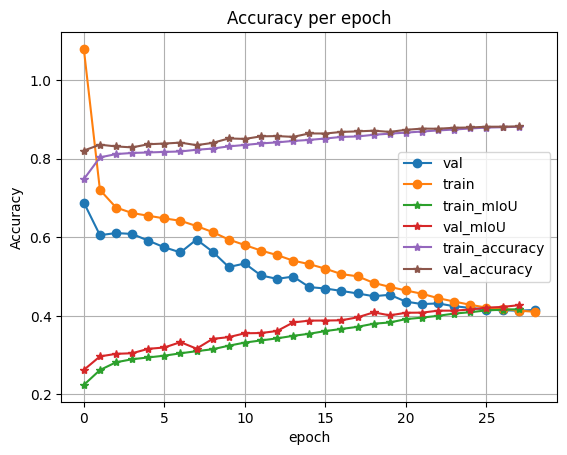

In [20]:
plot_loss(history, save_path = os.path.join(save_model_path, 'loss.png'))
plot_score(history, save_path = os.path.join(save_model_path, 'score.png'))
plot_acc(history, save_path = os.path.join(save_model_path, 'accuracy.png'))

### (4) Load Best model

In [21]:
best_model = torch.load(os.path.join(save_model_path, 'best_model.pt'))

## 6. Inference

### (1) Construct Inference Dataset

In [22]:
test_set = ConstructInferenceDataset(valid_image_list, valid_mask_list, validation_transform)

### (2) Sample Testset Visualize

In [23]:
sample_testset = get_samples(test_set, 5)

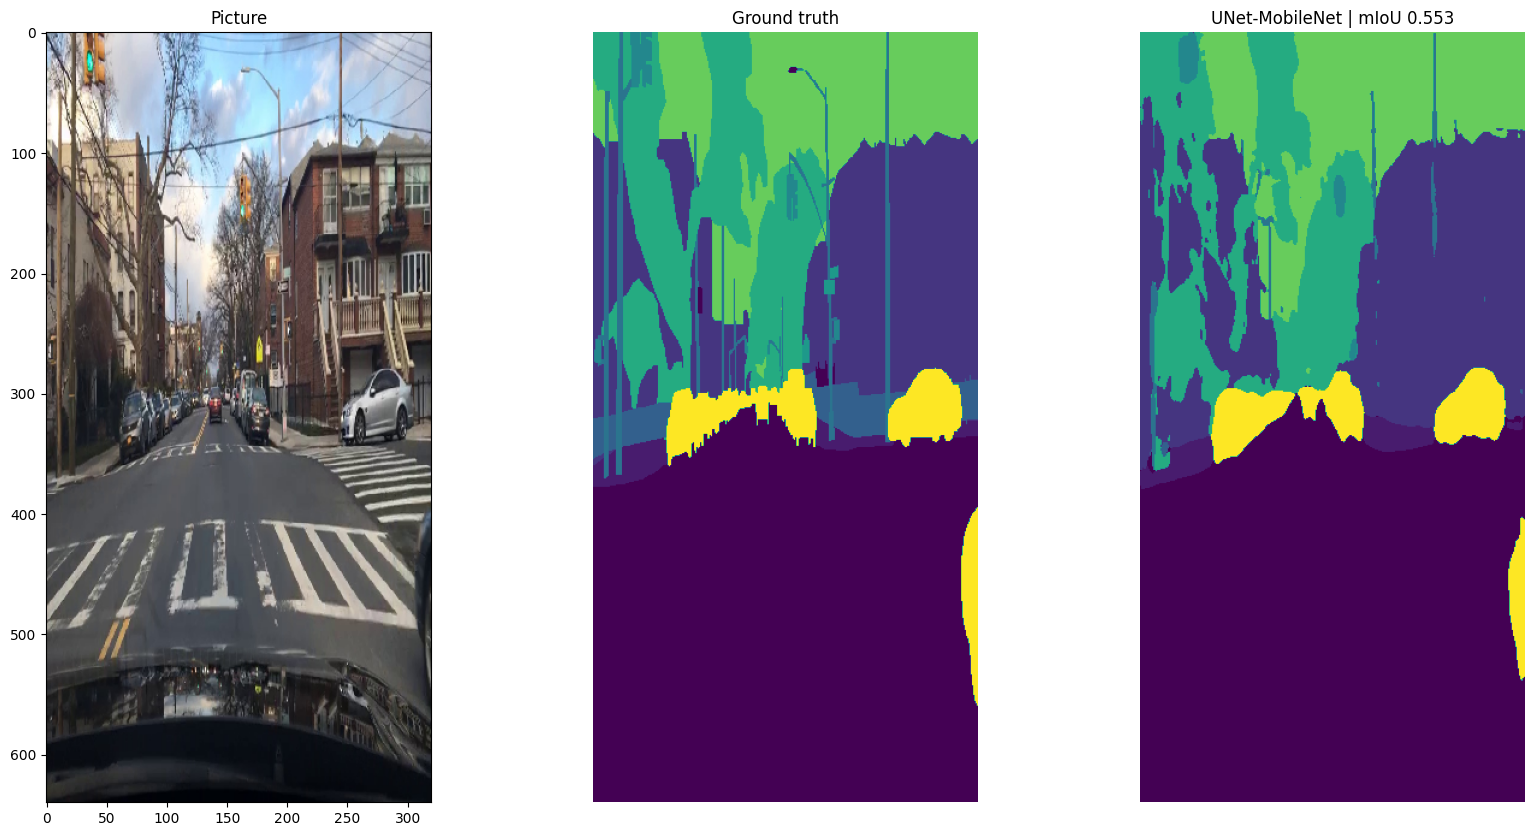

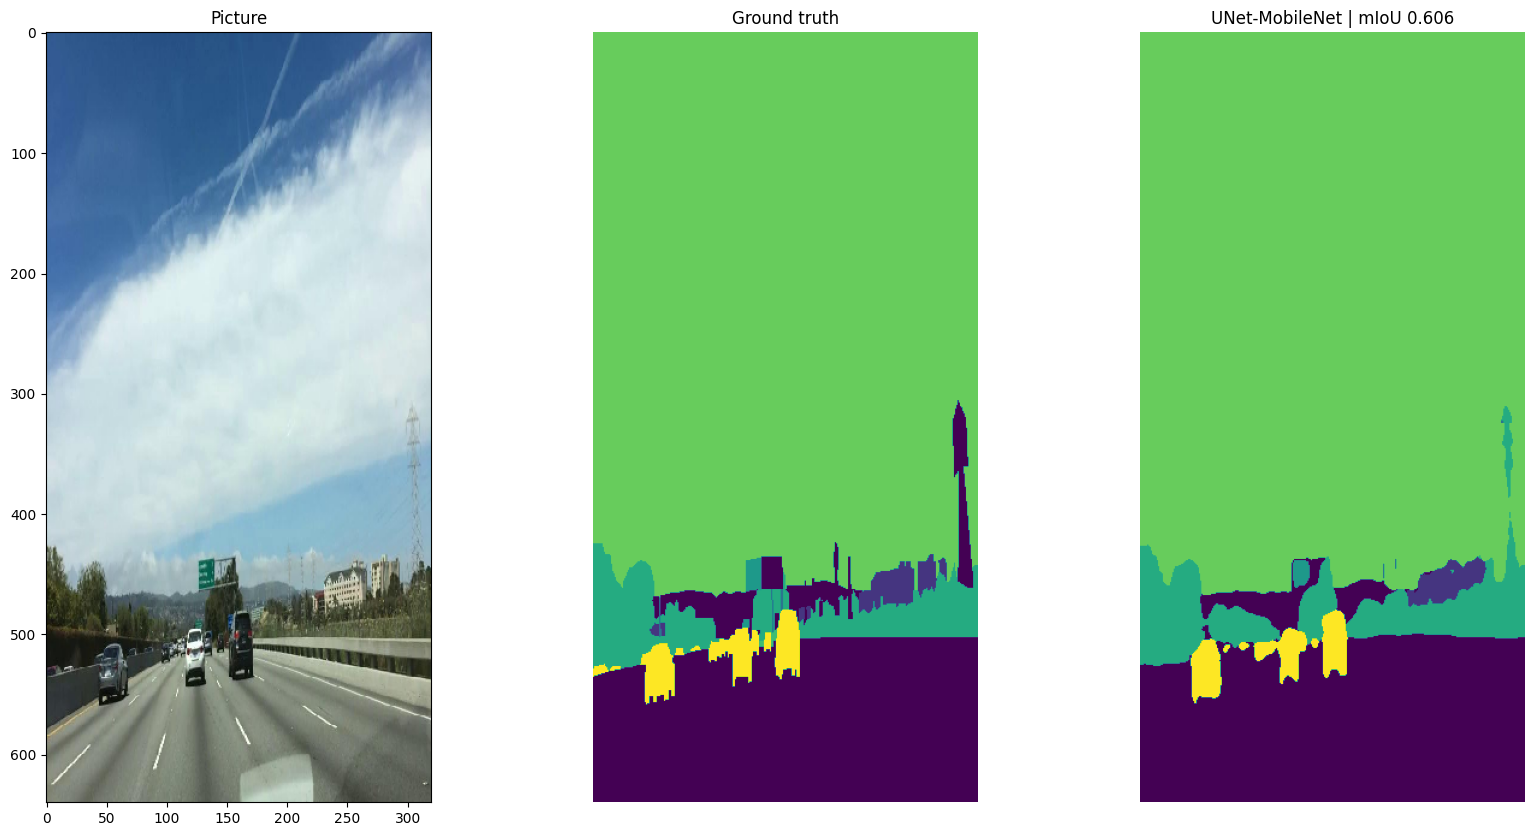

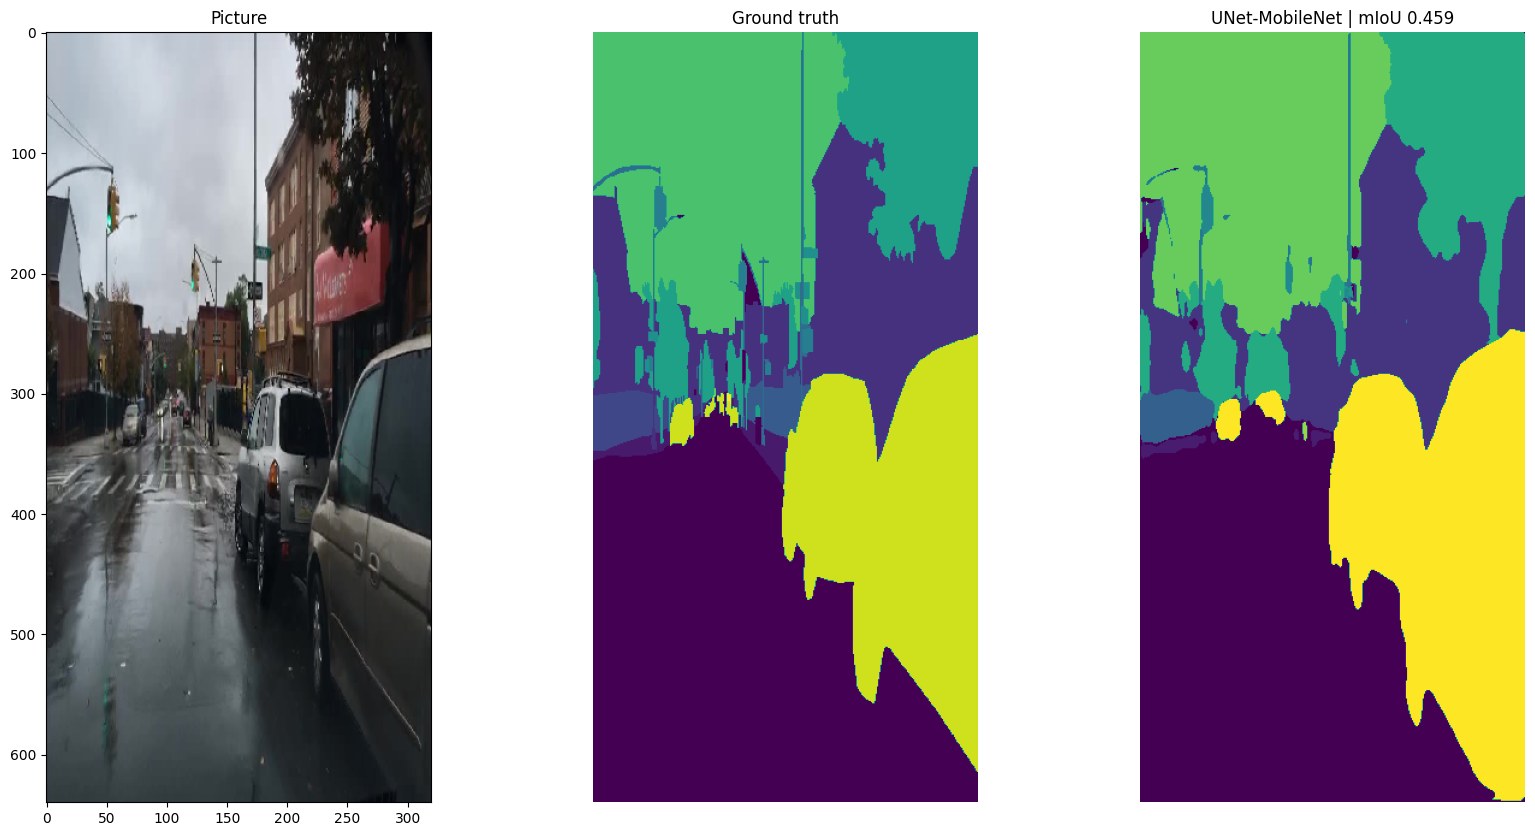

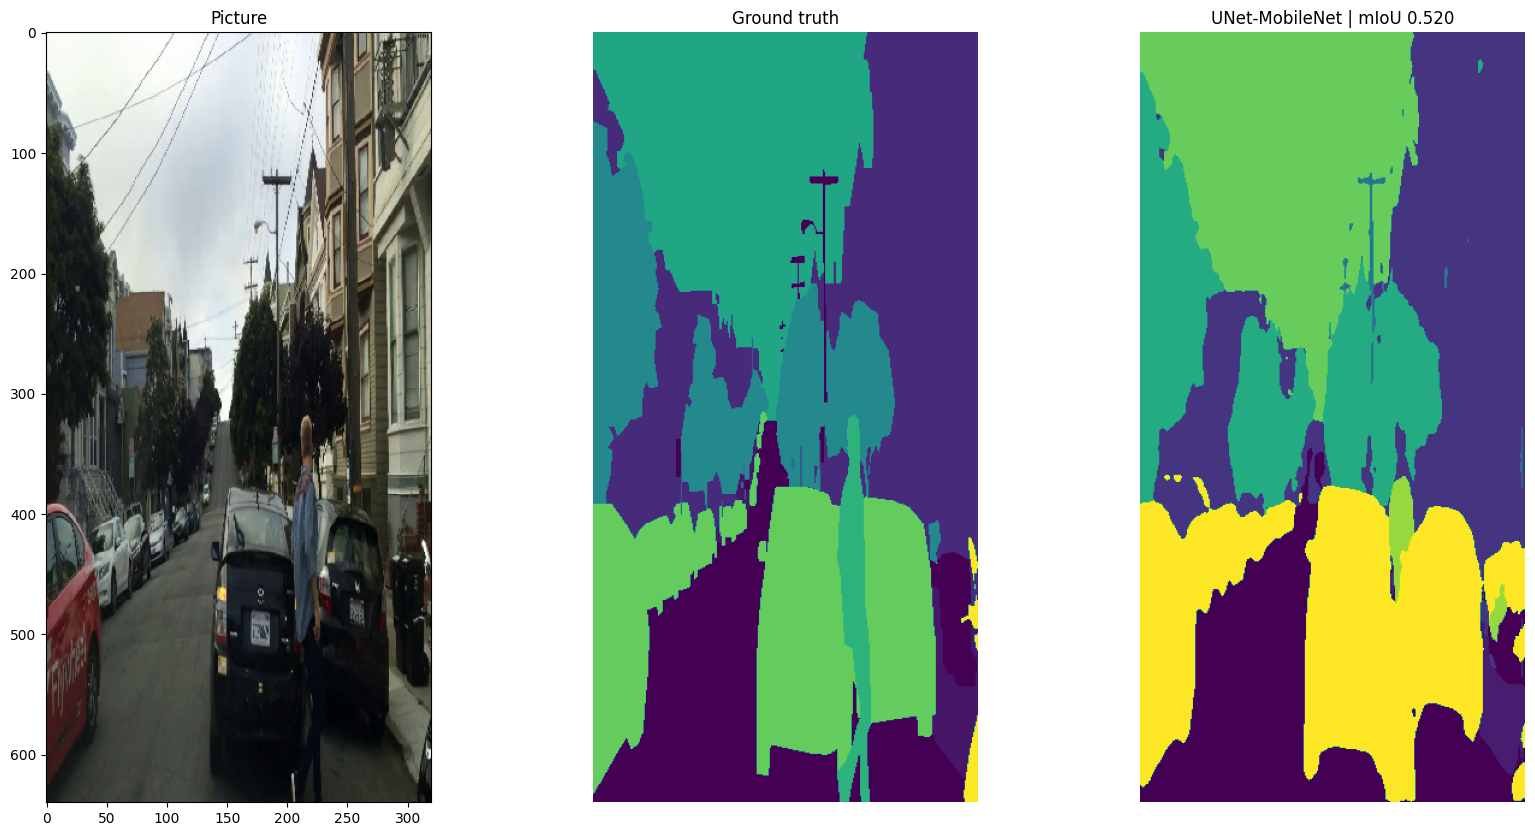

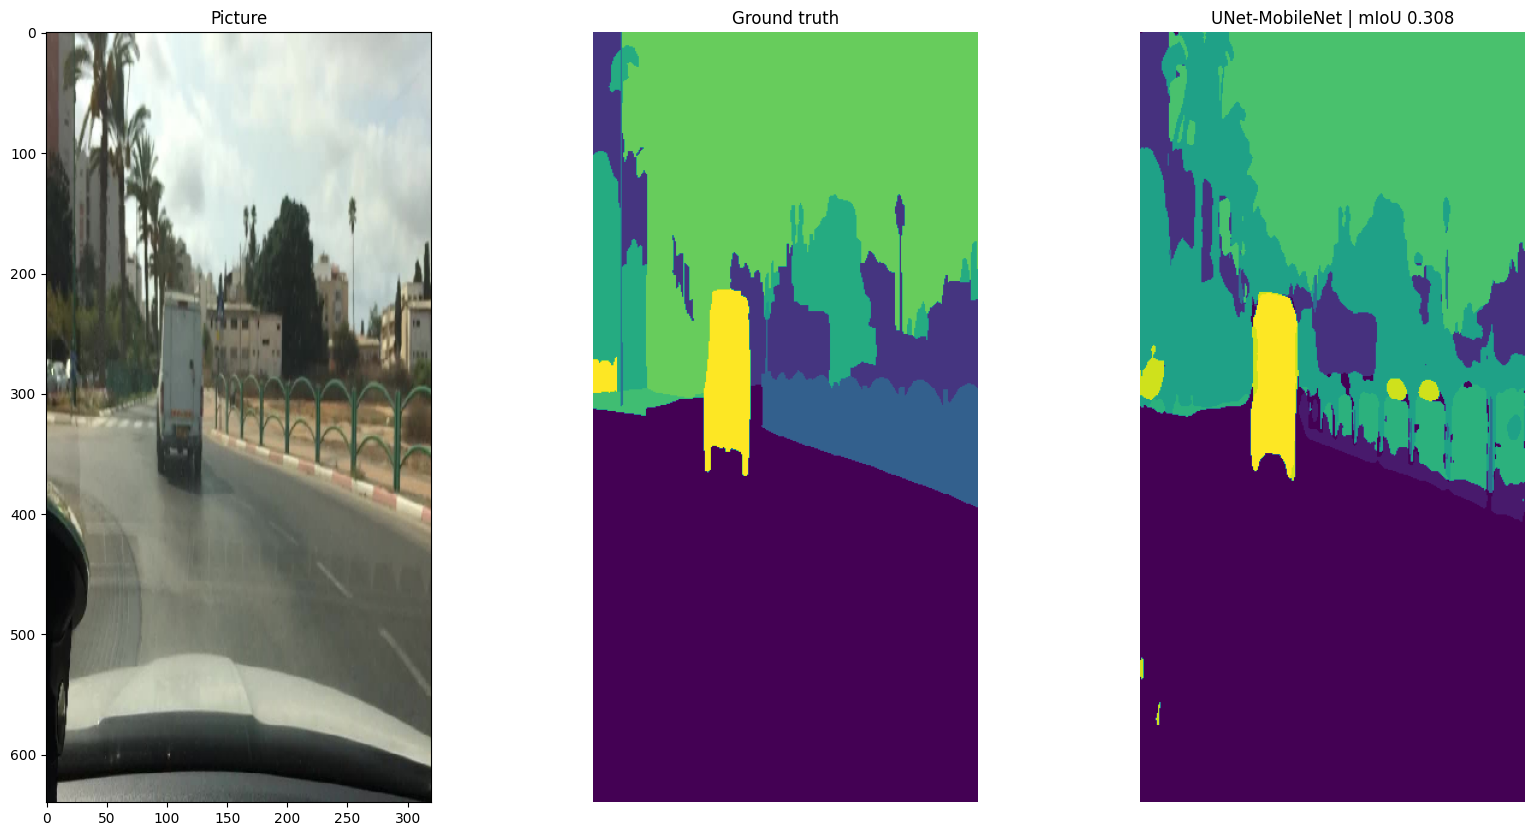

In [24]:
for (image, mask) in sample_testset:
    pred_mask, score = predict_image_mask_miou(best_model, image, mask, device)
    visualize_inference(image, mask, pred_mask, architecture = architecture, encoder_name = encoder_name, score = score)

### (3) Performance

In [24]:
mob_miou = miou_score(model, test_set, device)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/582 [00:00<?, ?it/s]


TypeError: predict_image_mask_miou() missing 1 required positional argument: 'device'

In [ ]:
mob_acc = pixel_acc(model, test_set, device)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

## 6. Video Segmentation

In [25]:
import cv2
import matplotlib.pyplot as plt

In [34]:
video_path = "dataset/video/dc90f082-3b51f12c.mov"
frame_path = "dataset/video/frames"
os.makedirs(frame_path, exist_ok=True)

In [35]:
cap = cv2.VideoCapture(video_path)

In [36]:
#불러온 비디오 파일의 정보 출력
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 1207
width : 1280
height : 720
fps : 30.02612048592396


In [37]:
def predict_image_mask_miou(model, image, device, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [30]:
img_array = []

from PIL import Image
for i in range(length):
    if i % 4 != 0:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame=cv2.flip(frame, -1)
        aug = validation_transform(image=frame, mask=frame)
        img = Image.fromarray(aug['image'])
        x = predict_image_mask_miou(best_model, img, device)
        img = np.array(img)
        img[x == 13, 0] = 0
        img[x == 13, 1] = 255
        img[x == 13, 2] = 255
        img = cv2.resize(img, (width, height))
        img_array.append(img)

    else:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame=cv2.flip(frame, -1)
        img_array.append(frame)


        

### All Object Detect

In [31]:
from scipy.io import loadmat
colormap = loadmat("./colormap.mat")["colormap"]

colormap = colormap * 255
colormap = colormap.astype('uint8')
colormap

array([[  0,   0,   0],
       [127,   0,   0],
       [254,   0,   0],
       [  0,  84,   0],
       [169,   0,  50],
       [254,  84,   0],
       [  0,   0,  84],
       [  0, 118, 220],
       [ 84,  84,   0],
       [  0,  84,  84],
       [ 84,  50,   0],
       [ 51,  85, 127],
       [  0, 127,   0],
       [  0,   0, 254],
       [ 50, 169, 220],
       [  0, 254, 254],
       [ 84, 254, 169],
       [169, 254,  84],
       [254, 254,   0],
       [254, 169,   0]], dtype=uint8)

In [38]:
def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay



In [39]:
img_array = []

from PIL import Image
for i in range(length):
    if 0 == 0:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame=cv2.flip(frame, -1)
        aug = validation_transform(image=frame, mask=frame)
        img = Image.fromarray(aug['image'])
        x = predict_image_mask_miou(best_model, img, device)
        color_mask = decode_segmentation_masks(x, colormap, n_classes = 19)
        img = get_overlay(img, color_mask)
        img = cv2.resize(img, (width, height))
        img_array.append(img)

    else:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame=cv2.flip(frame, -1)
        img_array.append(frame)


        

In [40]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

### Only Car Detect

In [45]:
video_path = "dataset/video/dc90f082-3b51f12c.mov"
frame_path = "dataset/video/frames"
os.makedirs(frame_path, exist_ok=True)

In [46]:
cap = cv2.VideoCapture(video_path)

In [47]:
#불러온 비디오 파일의 정보 출력
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 1207
width : 1280
height : 720
fps : 30.02612048592396


In [48]:
from scipy.io import loadmat
colormap = loadmat("./colormap.mat")["colormap"]

colormap = colormap * 255
colormap = colormap.astype('uint8')
colormap

array([[  0,   0,   0],
       [127,   0,   0],
       [254,   0,   0],
       [  0,  84,   0],
       [169,   0,  50],
       [254,  84,   0],
       [  0,   0,  84],
       [  0, 118, 220],
       [ 84,  84,   0],
       [  0,  84,  84],
       [ 84,  50,   0],
       [ 51,  85, 127],
       [  0, 127,   0],
       [  0,   0, 254],
       [ 50, 169, 220],
       [  0, 254, 254],
       [ 84, 254, 169],
       [169, 254,  84],
       [254, 254,   0],
       [254, 169,   0]], dtype=uint8)

In [49]:
def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay



In [59]:
img_array = []

from PIL import Image
for i in range(length):
    if 0 == 0:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame=cv2.flip(frame, -1)
        aug = validation_transform(image=frame, mask=frame)
        img = Image.fromarray(aug['image'])
        x = predict_image_mask_miou(best_model, img, device)
        img = np.array(img).astype(np.uint8)
        color_mask = decode_segmentation_masks(x, colormap, n_classes = 19)
        overlayed_img = get_overlay(img, color_mask)
        img[x == 13] = overlayed_img[x == 13]
        img = cv2.resize(img, (width, height))
        img_array.append(img)

    else:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame=cv2.flip(frame, -1)
        img_array.append(frame)


        

TypeError: image must be numpy array type

In [60]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()